In [ ]:
!pip install -q neuralprophet
!pip install autogluon
!pip uninstall torchvision torchaudio torchtext -y

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 28.6 MB/s eta 0:00:00
Found existing installation: torchvision 0.20.1
Uninstalling torchvision-0.20.1:
  Successfully uninstalled torchvision-0.20.1


# Libraries

In [ ]:
from tabulate import tabulate
from google.colab import drive
from google.colab import userdata
from google.colab import widgets

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error,  r2_score, mean_absolute_percentage_error
import os, pathlib, glob, math, random
import plotly.graph_objects as go

from neuralprophet import NeuralProphet, set_log_level, set_random_seed
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import torch.nn as nn

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
import keras

import warnings
warnings.filterwarnings("ignore")

ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.


In [ ]:
from sklearn.preprocessing import Normalizer

# Cargue de Google Drive y preprocesamiento inicial para el EDA

In [ ]:
### Configuración de enlace entre Colab y Google Drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Lee el archivo Excel
df = pd.read_excel("/content/drive/MyDrive/MODELO_LLUVIAS_RAW_DATA/raw_data_rain/P24 ESTACIONES CALI -SATiC.xlsx")

# Muestra las primeras filas del DataFrame (opcional)
df.head()

,estacion,codigo,parametro,fecha,valor,unidades
0,PLANTA RIO CAUCA,2620000103,PRECIPITACION DIARIA,1960-03-20,3.0,mm
1,PLANTA RIO CAUCA,2620000103,PRECIPITACION DIARIA,1960-03-21,20.0,mm
2,PLANTA RIO CAUCA,2620000103,PRECIPITACION DIARIA,1960-03-22,22.0,mm
3,PLANTA RIO CAUCA,2620000103,PRECIPITACION DIARIA,1960-03-23,2.0,mm
4,PLANTA RIO CAUCA,2620000103,PRECIPITACION DIARIA,1960-03-24,2.0,mm


In [ ]:
# Filter the DataFrame to include only data for the "AGUACATAL-MONTEBELLO" station.
df = df[df['estacion'] == 'AGUACATAL-MONTEBELLO']

In [ ]:
print("La dimensionalidad del dataframe es: ", df.shape)

La dimensionalidad del dataframe es:  (19500, 6)


In [ ]:
df = df.drop(['codigo', 'parametro', 'unidades', 'estacion'], axis=1) # Pass a single list of labels to drop
df.head()

,fecha,valor
93982,1969-07-09,0.0
93983,1969-07-10,10.0
93984,1969-07-11,0.0
93985,1969-07-12,0.0
93986,1969-07-13,0.0


In [ ]:
def visualizeDataBasics(df):
  #@title Visualize the Data in Facets
  fsg = FeatureStatisticsGenerator()
  dataframes = [
      {'table': df, 'name': 'trainData'}]
  censusProto = fsg.ProtoFromDataFrames(dataframes)
  protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")


  HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
          <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
          <facets-overview id="elem"></facets-overview>
          <script>
            document.querySelector("#elem").protoInput = "{protostr}";
          </script>"""
  html = HTML_TEMPLATE.format(protostr=protostr)
  display(HTML(html))


# Función para la creación de matrices de correlación entre variables

def makeCorrelationMatrix(df):
  # Select only numeric columns for correlation
  numeric = df.select_dtypes(include=['number']) # Select numeric columns
  corr = numeric.corr() # Calculate correlation on numeric columns only

  fig = go.Figure(data=go.Heatmap(
      z=corr.values,
      x=corr.columns,
      y=corr.columns,
      colorscale='Viridis'
  ))

  fig.update_layout(
      title='Matriz de correlación para el DataFrame',
      xaxis_title='Variables',
      yaxis_title='Variables'
  )

  fig.show()


def makeHistogram(df, x, y):
  # Generate histogram plot for "acumulado" vs "fecha_registro_dato_sensor" in cvc_df using plotly
  fig = px.histogram(df, x, y,
                  nbins=100, title=x + " vs " + y)
  fig.update_xaxes(tickformat="%d/%m/%Y")
  fig.show()

def makeLinePlot(df, x, y):
  # Generate line plot for the given DataFrame and columns using plotly
  fig = px.line(df, x=x, y=y, title=y + " vs " + x)
  fig.update_xaxes(tickformat="%d/%m/%Y")
  fig.show()

# Análisis Exploratorio de Datos (EDA)

Usaremos una serie de tiempo que contiene el registro histórico del comportamiento de temperatura diario desde 1981 hasta 1990.

# 2. Exploración inicial y limpieza de la Serie de Tiempo

Antes de comenzar a hacer el Análisis Exploratorio debemos verificar la integridad de los datos.

Usualmente esto implica:

1. Verificar los tipos de datos que tenemos
2. Verificar que el índice está en el formato *datetime* (para que sea una Serie de Tiempo en Pandas)
3. Realizar el manejo de registros duplicados (si existen)
4. Realizar el manejo de datos faltantes (si existen)

Veamos cómo llevar a cabo cada uno de estos pasos, comenzando con la verificación del tipo de datos que tenemos:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19500 entries, 93982 to 113481
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   19500 non-null  datetime64[ns]
 1   valor   19500 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 457.0 KB


Verifiquemos si existen registros (filas, en este caso temperaturas) duplicados:

In [ ]:
df.duplicated().any()

True

Lo importante es verificar que no existen fechas duplicadas, pues por cada día debemos tener un único registro. Esto lo podemos verificar accediendo al método `duplicated()` del índice:

In [ ]:
# Verificar si hay fechas duplicadas en el índice
df.index.duplicated().any()

False

No tenemos fechas duplicadas así que la Serie de Tiempo presenta una estructura adecuada para EDA. Verifiquemos si hay datos faltantes

In [ ]:
df.isna().sum()

,0
fecha,0
valor,0


Como se evidencian algunos datos faltantes (2), se realiza un proceso de imputación a través de una interpolación. Sin embargo existen otros enfoques y tecnicas que pueden ser mas preciso y dependerá de cada caso en particular.

In [ ]:
df = df.interpolate(method='linear')#.assign(Mes=lambda df: df.index.month)
df.head()

,fecha,valor
93982,1969-07-09,0.0
93983,1969-07-10,10.0
93984,1969-07-11,0.0
93985,1969-07-12,0.0
93986,1969-07-13,0.0


Grafico de la serie de tiempo

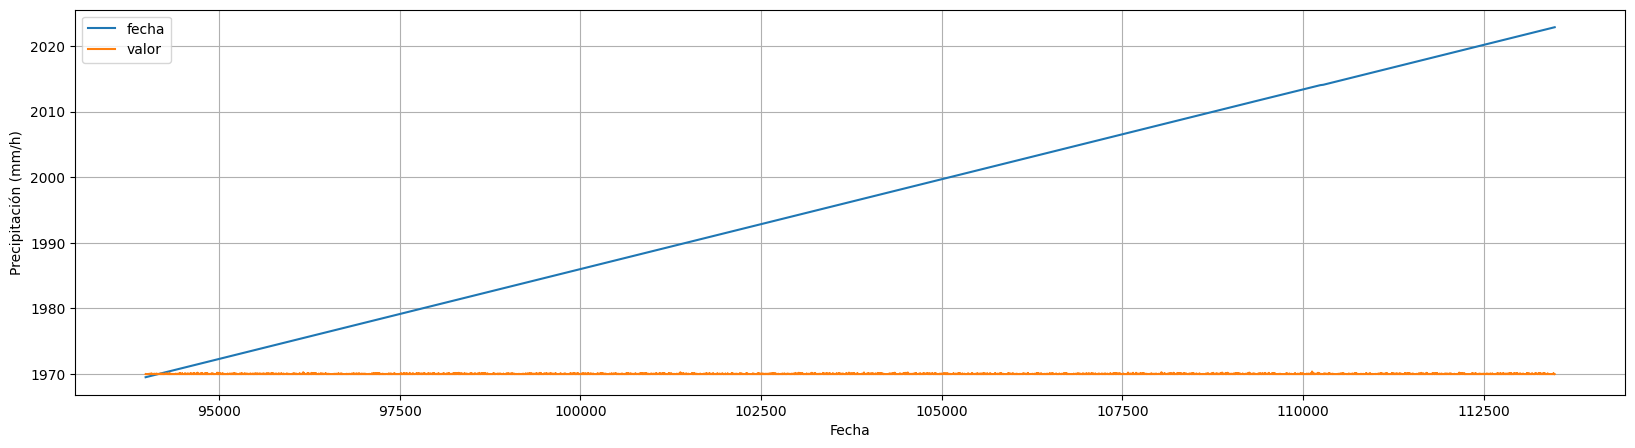

In [ ]:
ax = df.plot(figsize=(20,5), ylabel='Precipitación (mm/h)', xlabel="Fecha")
ax.grid();

In [ ]:
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler

df_keras = df.copy()
scaler_keras = MinMaxScaler() # Initialize scaler_keras with MinMaxScaler
df_keras['valor'] = scaler_keras.fit_transform(df[['valor']].values)
df_keras

,fecha,valor
93982,1969-07-09,0.000000
93983,1969-07-10,0.071429
93984,1969-07-11,0.000000
93985,1969-07-12,0.000000
93986,1969-07-13,0.000000
...,...,...
113477,2022-11-05,0.000000
113478,2022-11-06,0.000000
113479,2022-11-07,0.021429
113480,2022-11-08,0.050000


#3. Train-test Splitting

In [ ]:
df_keras = df_keras.set_index('fecha')

In [ ]:
df_keras

,valor
fecha,
1969-07-09,0.000000
1969-07-10,0.071429
1969-07-11,0.000000
1969-07-12,0.000000
1969-07-13,0.000000
...,...
2022-11-05,0.000000
2022-11-06,0.000000
2022-11-07,0.021429


In [ ]:
def partir_dataframe(df, fin_train, inicio_prueba):
  fin_train = fin_train #'2015-07-18 00:00:00'
  inicio_prueba = inicio_prueba #'2015-07-19 00:00:00'
  df_train, df_test = df.loc[: fin_train], df.loc[inicio_prueba:]
  train_size, test_size = df_train.shape[0], df_test.shape[0]
  print(f"Fechas train      : {df_train.index.min()} --- {df_train.index.max()}")
  print(f"Fechas test       : {df_test.index.min()} --- {df_test.index.max()}")

  return df_train, df_test

In [ ]:
df_train, df_test=partir_dataframe(df_keras, '2012-03-09 00:00:00', '2012-03-10 00:00:00')

Fechas train      : 1969-07-09 00:00:00 --- 2012-03-09 00:00:00
Fechas test       : 2012-03-10 00:00:00 --- 2022-11-09 00:00:00


In [ ]:
window = 6
horizon = 1

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    df = pd.DataFrame(data)
    n_vars = df.shape[1] if hasattr(df, 'shape') else 1
    cols = [df.shift(i) for i in range(n_in, 0, -1)] + [df.shift(-i) for i in range(n_out)]
    names = [f'var{j+1}(t{"+" if i > 0 else ""}{i})' for i in range(-n_in, n_out) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names[:agg.shape[1]]
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
train, test = series_to_supervised(df_train, window, horizon), series_to_supervised(df_test, window, horizon)
print(train.shape, test.shape)
X_train, X_test = train.values[:, 0:window].reshape(-1,window,1), test.values[:, 0:window].reshape(-1,window,1)
y_train, y_test = train.values[:, window:], test.values[:, window:]
print("--------\nEntrenamiento:",X_train.shape, y_train.shape,"\nPrueba:", X_test.shape, y_test.shape)

(15570, 7) (3918, 7)
--------
Entrenamiento: (15570, 6, 1) (15570, 1) 
Prueba: (3918, 6, 1) (3918, 1)


# 1. Transformers

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

In [ ]:
def build_te_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(horizon)(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = X_train.shape[1:]

model = build_te_model(
    input_shape,
    head_size=128,
    num_heads=4,
    ff_dim=2,
    num_transformer_blocks=3,
    mlp_units=[64],
    mlp_dropout=0.3,
    dropout=0.25,
)

model.compile('adam','huber', metrics=['mse'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 6, 1)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 6, 1)           │              2 │ input_layer[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 6, 1)           │          3,585 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 6, 1)           │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 6, 1)           │              0 │ dropout_1[0][0],       │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 6, 1)           │              2 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 6, 2)           │              4 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 6, 2)           │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 6, 1)           │              3 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 6, 1)           │              0 │ dense_1[0][0],         │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 6, 1)           │              2 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 6, 1)           │          3,585 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 6, 1)           │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 6, 1)           │              0 │ dropout_4[0][0],       │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 6, 1)           │              2 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 11,301 (44.14 KB)

 Trainable params: 11,301 (44.14 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [ModelCheckpoint(filepath='model_TE.best.keras', verbose = 1, save_best_only=True),\
             EarlyStopping(patience=15, restore_best_weights=True),\
             ReduceLROnPlateau(monitor='val_loss', patience = 4, verbose = 1, factor = 0.8, min_lr = 1e-5)]

historia = model.fit(X_train,y_train,
                     validation_split=0.2,
                     epochs=250,verbose=1,
                     callbacks=callbacks,shuffle=True)

Epoch 1/250
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0021 - mse: 0.0041
Epoch 1: val_loss improved from inf to 0.00194, saving model to model_TE.best.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - loss: 0.0021 - mse: 0.0041 - val_loss: 0.0019 - val_mse: 0.0039 - learning_rate: 0.0010
Epoch 2/250
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mse: 0.0037
Epoch 2: val_loss improved from 0.00194 to 0.00193, saving model to model_TE.best.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.0019 - mse: 0.0037 - val_loss: 0.0019 - val_mse: 0.0039 - learning_rate: 0.0010
Epoch 3/250
388/390 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - mse: 0.0037
Epoch 3: val_loss did not improve from 0.00193
390/390 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0018 - mse: 0.0037 - val_loss: 0.0020 - val_mse: 0.0039 - learning_rate: 0.0010
Epoch 4/250
388/390 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - mse: 0.0034
Epoch 4: val_loss improved from 0.00193 to 0.00193, s

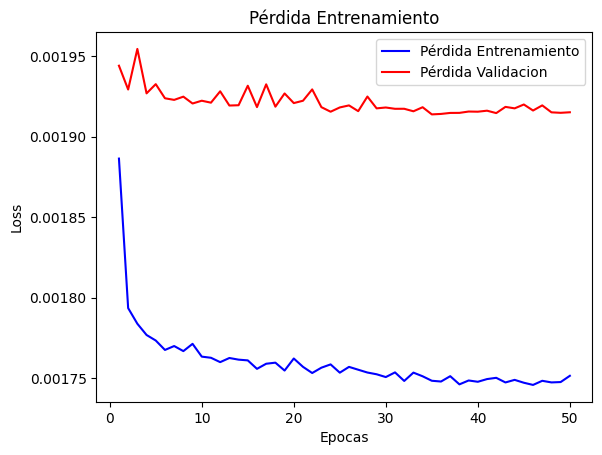

In [ ]:
perdida_train = historia.history['loss']
perdida_test = historia.history['val_loss']
epocas = range(1, len(perdida_train) + 1)

plt.plot(epocas, perdida_train, 'b', label='Pérdida Entrenamiento')
plt.plot(epocas, perdida_test, 'r', label='Pérdida Validacion')
plt.title('Pérdida Entrenamiento')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_te = load_model('model_TE.best.keras')
predictions_LSTM = model_te.predict(X_test)

123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


In [ ]:
print("RMSE:", root_mean_squared_error(scaler_keras.inverse_transform(y_test), scaler_keras.inverse_transform(predictions_LSTM)))
print("MAE:",mean_absolute_error(scaler_keras.inverse_transform(y_test), scaler_keras.inverse_transform(predictions_LSTM)))
print("MAPE:",mean_absolute_percentage_error(scaler_keras.inverse_transform(y_test), scaler_keras.inverse_transform(predictions_LSTM))*100)

RMSE: 8.47833272738031
MAE: 4.808523041597126
MAPE: 1.0101995257403638e+18


# 2. Neural Prophet

In [ ]:
df_train_NP, df_test_NP=partir_dataframe(df_keras, '2012-03-09 00:00:00', '2012-03-10 00:00:00')

Fechas train      : 1969-07-09 00:00:00 --- 2012-03-09 00:00:00
Fechas test       : 2012-03-10 00:00:00 --- 2022-11-09 00:00:00


In [ ]:
df_train_NP, df_test_NP = df_train_NP.reset_index(), df_test_NP.reset_index()
df_train_NP.rename(columns={'fecha':'ds', 'valor':'y'},inplace=True)
df_test_NP.rename(columns={'fecha':'ds', 'valor':'y'},inplace=True)
df_train_NP

,ds,y
0,1969-07-09,0.000000
1,1969-07-10,0.071429
2,1969-07-11,0.000000
3,1969-07-12,0.000000
4,1969-07-13,0.000000
...,...,...
15571,2012-03-05,0.014286
15572,2012-03-06,0.000000
15573,2012-03-07,0.000000
15574,2012-03-08,0.000000


In [ ]:
set_random_seed(42)
quantiles = [0.05, 0.95]
params = {
    'quantiles':quantiles,
    'growth':'discontinuous',
    'n_forecasts': 10,
    #'ar_layers':[15,15],
    'optimizer':'AdamW',
    'loss_func':nn.HuberLoss,
    'yearly_seasonality':True,
    #'daily_seasonality':True,
    #'n_lags':20,
    'n_changepoints':366,
    'changepoints_range': 0.9,
    'epochs': 300
}
m = NeuralProphet(**params)
#m.add_future_regressor("Mes")
train, val = m.split_df(df_train_NP, freq='D', valid_p=0.2)
test = df_test_NP
metricas = m.fit(train, freq = "D", validation_df=val, early_stopping=True, checkpointing=True)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.936% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.936% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.968% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.968% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is e

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (98) is too small than the required number                     for the learning rate finder (252). The results might not be optimal.


Finding best initial lr:   0%|          | 0/252 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
hist_fitting = m.predict(train)
metricas

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.968% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.968% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.968% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.968% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
0,0.072452,0.097039,0.297120,0.0,0,0.553603,0.0,0.089677,0.114799,0.552179,0.0
1,0.048741,0.075532,0.176682,0.0,1,0.203589,0.0,0.059742,0.081476,0.203490,0.0
2,0.036453,0.067129,0.147208,0.0,2,0.116352,0.0,0.043406,0.066673,0.116227,0.0
3,0.030599,0.064554,0.135930,0.0,3,0.094998,0.0,0.035703,0.060561,0.094816,0.0
4,0.028686,0.063849,0.130190,0.0,4,0.086683,0.0,0.032892,0.058593,0.086591,0.0
5,0.028873,0.063693,0.126373,0.0,5,0.083077,0.0,0.032051,0.057349,0.082627,0.0
6,0.028288,0.063874,0.123971,0.0,6,0.081287,0.0,0.032040,0.057434,0.081591,0.0
7,0.029610,0.063745,0.121720,0.0,7,0.080322,0.0,0.032130,0.057414,0.080254,0.0
8,0.028014,0.063919,0.120109,0.0,8,0.079714,0.0,0.031978,0.057382,0.079502,0.0
9,0.029812,0.063543,0.118404,0.0,9,0.079310,0.0,0.031891,0.057429,0.079054,0.0


In [ ]:
hist_fitting

,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_yearly,season_weekly
0,1969-07-09,0.000000,0.003311,-0.017222,0.019901,0.013915,-0.006732,-0.003871
1,1969-07-10,0.071429,0.002272,-0.013673,0.027609,0.013909,-0.007024,-0.004613
2,1969-07-11,0.000000,0.007219,-0.011751,0.030044,0.013904,-0.007324,0.000639
3,1969-07-12,0.000000,0.008720,-0.004903,0.033123,0.013899,-0.007632,0.002454
4,1969-07-13,0.000000,0.010563,-0.009449,0.049137,0.013894,-0.007949,0.004619
...,...,...,...,...,...,...,...,...
12451,2003-08-14,0.000000,0.006541,-0.012306,0.060527,0.025150,-0.013998,-0.004611
12452,2003-08-15,0.000000,0.011983,-0.010733,0.066432,0.025150,-0.013802,0.000635
12453,2003-08-16,0.000000,0.014026,-0.004179,0.073105,0.025150,-0.013579,0.002454
12454,2003-08-17,0.000000,0.016438,-0.008992,0.092729,0.025151,-0.013329,0.004617


In [ ]:
# Crear figura
fig = go.Figure()
# Línea de valores actuales
fig.add_trace(go.Scatter(x=train['ds'], y=train['y'], mode='lines', name='Datos Históricos'))

# Línea de pronóstico
fig.add_trace(go.Scatter(x=hist_fitting['ds'], y=hist_fitting['yhat1'], mode='lines', name='Pronóstico'))

fig.add_trace(go.Scatter(
    x=hist_fitting['ds'], y=hist_fitting['yhat1 95.0%'],
    mode='lines',
    line=dict(width=0),  # Sin línea, solo rellenar
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=hist_fitting['ds'], y=hist_fitting['yhat1 5.0%'],
    mode='lines',
    fill='tonexty',  # Rellenar entre esta traza y la anterior
    line=dict(width=0),  # Sin línea
    fillcolor='rgba(173, 216, 230, 0.3)',  # Color azul claro con transparencia
    showlegend=False
))

fig.update_layout(title=f"<b>Temperatura</b>",
                  plot_bgcolor='rgba(0,0,0,0)',
                  width=1000,height=400,
                  margin=dict(r=100, t=80, l=80),
                  yaxis=dict(color="black"),
                  xaxis=dict(color="black"),
                  font=dict(family="Futura LT", color='black'),
                  legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1, font_size=16, font_color='black'),
                  showlegend=True)

fig.update_xaxes(showline=True, linewidth=1, linecolor='black', gridcolor='lightgray', mirror=False, title_text='<b>Tiempo (Día)</b>', titlefont_size=18, tickfont_size=16)
fig.update_yaxes(showline=True, linewidth=1, gridcolor='lightgray', linecolor='black', mirror=False, title_text='<b>Precipitación (Día)</b>', titlefont_size=18, tickfont_size=16, tickformat='.2f')
fig.update_traces(
    hovertemplate='<b>Fecha:</b> %{x}<br><b>Precipitación:</b> %{y:.2f} °C<extra></extra>'
)

fig.show()

In [ ]:
def tmape(y_true, y_pred, threshold=0.1):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = np.abs(y_true) > threshold
    return 100 * mean_absolute_percentage_error(y_true[mask],y_pred[mask])

In [ ]:
error_metrics_train = {'RMSE':root_mean_squared_error(train['y'], hist_fitting['yhat1']),
                       'MAE':mean_absolute_error(train['y'].values.reshape(-1,1), hist_fitting['yhat1'].values.reshape(-1,1)),
                       'MAPE':round(tmape(train['y'], hist_fitting['yhat1']),3)
                      }
print(error_metrics_train)

{'RMSE': 0.05857356306892064, 'MAE': 0.032959108521499955, 'MAPE': 81.764}


In [ ]:
# Assuming df_test_NP is your DataFrame

# Drop duplicate rows based on the 'ds' column, keeping the first occurrence
df_test_NP = df_test_NP.drop_duplicates(subset=['ds'], keep='first')

# Now, try predicting again
forecast = m.predict(df_test_NP)
forecast

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.872% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.872% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.872% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.872% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


,ds,y,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_yearly,season_weekly
0,2012-03-10,0.000000,0.037796,-0.011293,0.151955,0.025629,0.009713,0.002453
1,2012-03-11,0.000000,0.040336,-0.015415,0.170959,0.025629,0.010090,0.004617
2,2012-03-12,0.035714,0.036215,-0.016996,0.146156,0.025630,0.010422,0.000164
3,2012-03-13,0.000000,0.036943,-0.011879,0.155441,0.025630,0.010707,0.000606
4,2012-03-14,0.000000,0.032702,-0.021144,0.138372,0.025630,0.010947,-0.003875
...,...,...,...,...,...,...,...,...
3888,2022-11-05,0.000000,0.040605,-0.031830,0.187455,0.026225,0.011925,0.002455
3889,2022-11-06,0.000000,0.042659,-0.036234,0.205782,0.026225,0.011818,0.004617
3890,2022-11-07,0.021429,0.038046,-0.038080,0.180295,0.026225,0.011655,0.000166
3891,2022-11-08,0.050000,0.038271,-0.033226,0.188815,0.026225,0.011438,0.000608


In [ ]:
# Crear figura
fig = go.Figure()
# Línea de valores actuales
fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], mode='lines', name='Datos Históricos'))

# Línea de pronóstico
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat1'], mode='lines', name='Pronóstico'))

fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat1 95.0%'],
    mode='lines',
    line=dict(width=0),  # Sin línea, solo rellenar
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=forecast['ds'], y=forecast['yhat1 5.0%'],
    mode='lines',
    fill='tonexty',  # Rellenar entre esta traza y la anterior
    line=dict(width=0),  # Sin línea
    fillcolor='rgba(173, 216, 230, 0.3)',  # Color azul claro con transparencia
    showlegend=False
))

fig.update_layout(title=f"<b>Precipitación</b>",
                  plot_bgcolor='rgba(0,0,0,0)',
                  width=1000,height=400,
                  margin=dict(r=100, t=80, l=80),
                  yaxis=dict(color="black"),
                  xaxis=dict(color="black"),
                  font=dict(family="Futura LT", color='black'),
                  legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1, font_size=16, font_color='black'),
                  showlegend=True)

fig.update_xaxes(showline=True, linewidth=1, linecolor='black', gridcolor='lightgray', mirror=False, title_text='<b>Tiempo (Día)</b>', titlefont_size=18, tickfont_size=16)
fig.update_yaxes(showline=True, linewidth=1, gridcolor='lightgray', linecolor='black', mirror=False, title_text='<b>Precipitación (Día)</b>', titlefont_size=18, tickfont_size=16, tickformat='.2f')
fig.update_traces(
    hovertemplate='<b>Fecha:</b> %{x}<br><b>Precipitación:</b> %{y:.2f} °C<extra></extra>'
)

fig.show()

In [ ]:
# Merge 'test' and 'forecast' DataFrames on the 'ds' column
merged_df = pd.merge(test[['ds', 'y']], forecast[['ds', 'yhat1']], on='ds', how='inner')

# Calculate error metrics using the merged DataFrame
error_metrics_train = {
    'RMSE': root_mean_squared_error(merged_df['y'], merged_df['yhat1']),
    'MAE': mean_absolute_error(merged_df['y'], merged_df['yhat1']),
    'MAPE': round(tmape(merged_df['y'], merged_df['yhat1']), 3)
}

print(error_metrics_train)

{'RMSE': 0.06048775639040946, 'MAE': 0.035409049521885526, 'MAPE': 82.406}


# 3. AutoGluon

In [ ]:
df['ID']=1
df.reset_index(inplace=True)
df

,index,fecha,valor,ID
0,93982,1969-07-09,0.0,1
1,93983,1969-07-10,10.0,1
2,93984,1969-07-11,0.0,1
3,93985,1969-07-12,0.0,1
4,93986,1969-07-13,0.0,1
...,...,...,...,...
19495,113477,2022-11-05,0.0,1
19496,113478,2022-11-06,0.0,1
19497,113479,2022-11-07,3.0,1
19498,113480,2022-11-08,7.0,1


In [ ]:
data_Prep_AG = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="ID",
    timestamp_column="fecha"
)
data_Prep_AG.tail()

index  valor
item_id timestamp                
1       2022-11-05  113477    0.0
        2022-11-06  113478    0.0
        2022-11-07  113479    3.0
        2022-11-08  113480    7.0
        2022-11-09  113481    2.0

In [ ]:
prediction_length = 730
train_data, test_data = data_Prep_AG.train_test_split(prediction_length)

In [ ]:
test_data

index  valor
item_id timestamp                
1       1969-07-09   93982    0.0
        1969-07-10   93983   10.0
        1969-07-11   93984    0.0
        1969-07-12   93985    0.0
        1969-07-13   93986    0.0
...                    ...    ...
        2022-11-05  113477    0.0
        2022-11-06  113478    0.0
        2022-11-07  113479    3.0
        2022-11-08  113480    7.0
        2022-11-09  113481    2.0

[19500 rows x 2 columns]

In [ ]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length,
                                quantile_levels=[0.05,0.95],
                                freq="D",eval_metric="MAPE",
                                target="valor")

In [ ]:
predictor.fit(train_data,num_val_windows=3,
              presets='best_quality',
              time_limit=1000)

Beginning AutoGluon training... Time limit = 1000s
AutoGluon will save models to '/content/AutogluonModels/ag-20241201_000711'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       8.77 GB / 12.67 GB (69.2%)
Disk Space Avail:   78.78 GB / 112.64 GB (69.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'freq': 'D',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 730,
 'quantile_levels': [0.05, 0.95],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'valor',
 'time_limit': 1000,
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'D'.
Provi

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/821M [00:00<?, ?B/s]

	Quantiles to be predicted ([0.05, 0.5, 0.95]) are not within the range of quantiles that Chronos-Bolt was trained on ([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]). Quantile predictions will be set to the minimum/maximum levels at which Chronos-Bolt was trained on. This may significantly affect the quality of the predictions.
	Quantiles to be predicted ([0.05, 0.5, 0.95]) are not within the range of quantiles that Chronos-Bolt was trained on ([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]). Quantile predictions will be set to the minimum/maximum levels at which Chronos-Bolt was trained on. This may significantly affect the quality of the predictions.
	Quantiles to be predicted ([0.05, 0.5, 0.95]) are not within the range of quantiles that Chronos-Bolt was trained on ([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]). Quantile predictions will be set to the minimum/maximum levels at which Chronos-Bolt was trained on. This may significantly affect the quality of the predictions.
	-0.9682  

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

	Saving fine-tuned model to /content/AutogluonModels/ag-20241201_000711/models/ChronosFineTuned[bolt_small]/W0/fine-tuned-ckpt
	Quantiles to be predicted ([0.05, 0.5, 0.95]) are not within the range of quantiles that Chronos-Bolt was trained on ([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]). Quantile predictions will be set to the minimum/maximum levels at which Chronos-Bolt was trained on. This may significantly affect the quality of the predictions.
	Saving fine-tuned model to /content/AutogluonModels/ag-20241201_000711/models/ChronosFineTuned[bolt_small]/W1/fine-tuned-ckpt
	Quantiles to be predicted ([0.05, 0.5, 0.95]) are not within the range of quantiles that Chronos-Bolt was trained on ([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]). Quantile predictions will be set to the minimum/maximum levels at which Chronos-Bolt was trained on. This may significantly affect the quality of the predictions.
	Saving fine-tuned model to /content/AutogluonModels/ag-20241201_000711/models/Chronos

In [ ]:
forecast = predictor.predict(train_data)

data with frequency 'None' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [ ]:
error_metrics = {'RMSE':root_mean_squared_error(data_Prep_AG.valor.values[-730:], forecast["mean"].values),
                 'MAE':mean_absolute_error(data_Prep_AG.valor.values[-730:], forecast["mean"].values),
                 'MAPE':mean_absolute_percentage_error(data_Prep_AG.valor.values[-730:], forecast["mean"].values)*100,
                 }
print(error_metrics)

{'RMSE': 9.568974230227377, 'MAE': 4.491900859039371, 'MAPE': 4.738223560801104e+17}


In [ ]:
forecast

mean       0.05       0.95
item_id timestamp                                 
1       2020-11-10  1.558175  -5.399402  12.907573
        2020-11-11  1.558521  -5.381844  12.514116
        2020-11-12  1.545908  -5.454448  14.001983
        2020-11-13  1.568537  -5.443901  12.907248
        2020-11-14  1.586274  -5.462794  12.659364
...                      ...        ...        ...
        2022-11-05  1.575082 -13.906052  21.643951
        2022-11-06  1.587520 -13.912509  21.606746
        2022-11-07  1.599663 -13.901139  21.319223
        2022-11-08  1.564596 -13.929405  21.159128
        2022-11-09  1.562141 -13.931485  21.662691

[730 rows x 3 columns]

In [ ]:
# Crear figura
fig = go.Figure()
# Línea de valores actuales
fig.add_trace(go.Scatter(x=df.fecha.values[-730:], y=data_Prep_AG.valor.values[-730:], mode='lines', name='Datos Históricos'))

# Línea de pronóstico
fig.add_trace(go.Scatter(x=df.fecha.values[-730:], y=forecast['mean'], mode='lines', name='Pronóstico'))

fig.add_trace(go.Scatter(
    x=df.fecha.values[-730:], y=forecast['0.95'],
    mode='lines',
    line=dict(width=0),  # Sin línea, solo rellenar
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=df.fecha.values[-730:], y=forecast['0.05'],
    mode='lines',
    fill='tonexty',  # Rellenar entre esta traza y la anterior
    line=dict(width=0),  # Sin línea
    fillcolor='rgba(173, 216, 230, 0.3)',  # Color azul claro con transparencia
    showlegend=False
))

fig.update_layout(title=f"<b>Temperatura</b>",
                  plot_bgcolor='rgba(0,0,0,0)',
                  width=1000,height=400,
                  margin=dict(r=100, t=80, l=80),
                  yaxis=dict(color="black"),
                  xaxis=dict(color="black"),
                  font=dict(family="Futura LT", color='black'),
                  legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1, font_size=16, font_color='black'),
                  showlegend=True)

fig.update_xaxes(showline=True, linewidth=1, linecolor='black', gridcolor='lightgray', mirror=False, title_text='<b>Tiempo (Día)</b>', titlefont_size=18, tickfont_size=16)
fig.update_yaxes(showline=True, linewidth=1, gridcolor='lightgray', linecolor='black', mirror=False, title_text='<b>Temperatura (Día)</b>', titlefont_size=18, tickfont_size=16, tickformat='.2f')
fig.update_traces(
    hovertemplate='<b>Fecha:</b> %{x}<br><b>Temperatura:</b> %{y:.2f} °C<extra></extra>'
)

fig.show()